# **Rejection Evaluation**
***

we trained resnet18 on the BUSI dataset using different scoring methods. The output is a csv file containing the scores. let's have a look at it:

In [1]:
import pandas as pd
output_path = r"C:\Computer_Vision\Medical_Images_With_Rejection\failure_detection_benchmark\outputs\BUSI\resnet18\dropout_all_layers_autolr_longer\seed_55\failure_detection\scores_df.csv"
scores_df = pd.read_csv(output_path)
scores_df.head()

,Targets,Predictions,IsCorrect,Baseline,doctor_alpha,mcmc_soft_scores,mcmc_predictions,mcmc_probas,mcmc_entropy_scores,Laplace_targets,Laplace_predictions,Laplace_score,TrustScore,ConfidNet_scores,SWAG_targets,SWAG_predictions,SWAG_score
0,0,1,False,0.524360,-1.434551,0.530867,1,NaN,-0.980445,0,1,0.484521,0.816372,0.602818,0,0,0.631612
1,0,1,False,0.961555,-0.080605,0.954375,1,NaN,-0.215710,0,1,0.901099,1.194050,0.634637,0,0,0.587070
2,0,1,False,0.572684,-1.147635,0.556334,1,NaN,-0.867243,0,1,0.533369,1.030615,0.596464,0,0,0.922435
3,0,1,False,0.534838,-1.157264,0.529195,1,NaN,-0.841670,0,1,0.507450,0.919911,0.598270,0,0,0.638138
4,0,1,False,0.510129,-1.142973,0.527342,1,NaN,-0.849199,0,1,0.487452,0.789352,0.614923,0,1,0.661010


We can see that the classes were encoded as 0,1,2. In general, normal is encoded as 0, benign is encoded as 1 and malignant is encoded as 2.
The dataframe consists of the following columns:
* Targets - Our GT classes.
* Predictions - The predicted classes
* IsCorrect - Is that classification correct or not?
* Baseline - Baseline softmax scorer.
* doctor_alpha - It is a scorer that quantifies the likelihood of being misclassified , and thus negative (as stated in the article).
* mcmc-soft-scores, mcmc-entropy scores - From the paper: "MC-dropout (MC): Gal & Ghahramani (2016) showed that training a neural network with dropout
regularization (Srivastava et al., 2014) produces a Bayesian approximation of the posterior, where the
approximation is obtained by Monte-Carlo sampling of the network’s parameters i.e. by applying
dropout at test-time and averaging the outputs over several inference passes. The confidence in
the prediction can then be approximated by the negative entropy of the outputs; or by taking the
softmax confidence score on the averaged outputs."
* mcmc predictions - predictions made by using Monte-Carlo sampling on the network's parameters.
* mcmc_probas - probabilities of the predictions for monte-carlo sampling (We can notice that it contains NaN values, we might consider dropping it).
* Laplace_targets - The targets for the laplace method. They are the same as the general targets.
* Laplace predictions - predictions made by Laplace
* Laplace score -Laplace confidence score
* TrustScore - Score made by TrustScore scorer.
* ConfidNet score- scores made by ConfidNet
* SWAG_targets - targets for SWAG method. The same as the general targets.
* SWAG_predictions - The predictions made by SWAG
* SWAG_score - SWAG confidence scores

We used The Baseline scorer, doctor-alpha, MC- softmax, MC- entropy, Laplace, TrustScore, ConfidNet, and SWAG (8 overall). The ones missing (as compared to the paper) are DUQ (which we failed to train due to insufficient CUDA memory) and ensemble (we used only 1 seed so ensemble is irrelevant).


Let's focus on that mcmc_probas column. let's check how many missing values it has:

In [2]:
print(f'{scores_df["mcmc_probas"].isna().sum() / len(scores_df["mcmc_probas"]) * 100} % missing values in mcmc_probas column')

100.0 % missing values in mcmc_probas column


Since all values in this column are missing, we will just drop it:

In [3]:
scores_df = scores_df.drop(columns=['mcmc_probas'])
scores_df.head()

,Targets,Predictions,IsCorrect,Baseline,doctor_alpha,mcmc_soft_scores,mcmc_predictions,mcmc_entropy_scores,Laplace_targets,Laplace_predictions,Laplace_score,TrustScore,ConfidNet_scores,SWAG_targets,SWAG_predictions,SWAG_score
0,0,1,False,0.524360,-1.434551,0.530867,1,-0.980445,0,1,0.484521,0.816372,0.602818,0,0,0.631612
1,0,1,False,0.961555,-0.080605,0.954375,1,-0.215710,0,1,0.901099,1.194050,0.634637,0,0,0.587070
2,0,1,False,0.572684,-1.147635,0.556334,1,-0.867243,0,1,0.533369,1.030615,0.596464,0,0,0.922435
3,0,1,False,0.534838,-1.157264,0.529195,1,-0.841670,0,1,0.507450,0.919911,0.598270,0,0,0.638138
4,0,1,False,0.510129,-1.142973,0.527342,1,-0.849199,0,1,0.487452,0.789352,0.614923,0,1,0.661010


Let's check for missing values once again:

In [4]:
print(f'{scores_df.isna().sum().sum() / scores_df.shape[0] * 100} % missing values in the dataframe')

0.0 % missing values in the dataframe


## **Thresholding**
***

Now that we have no missing values in the dataframe, we can find thresholds for separating the correct classifications from the incorrect ones, for each class and scoring method:

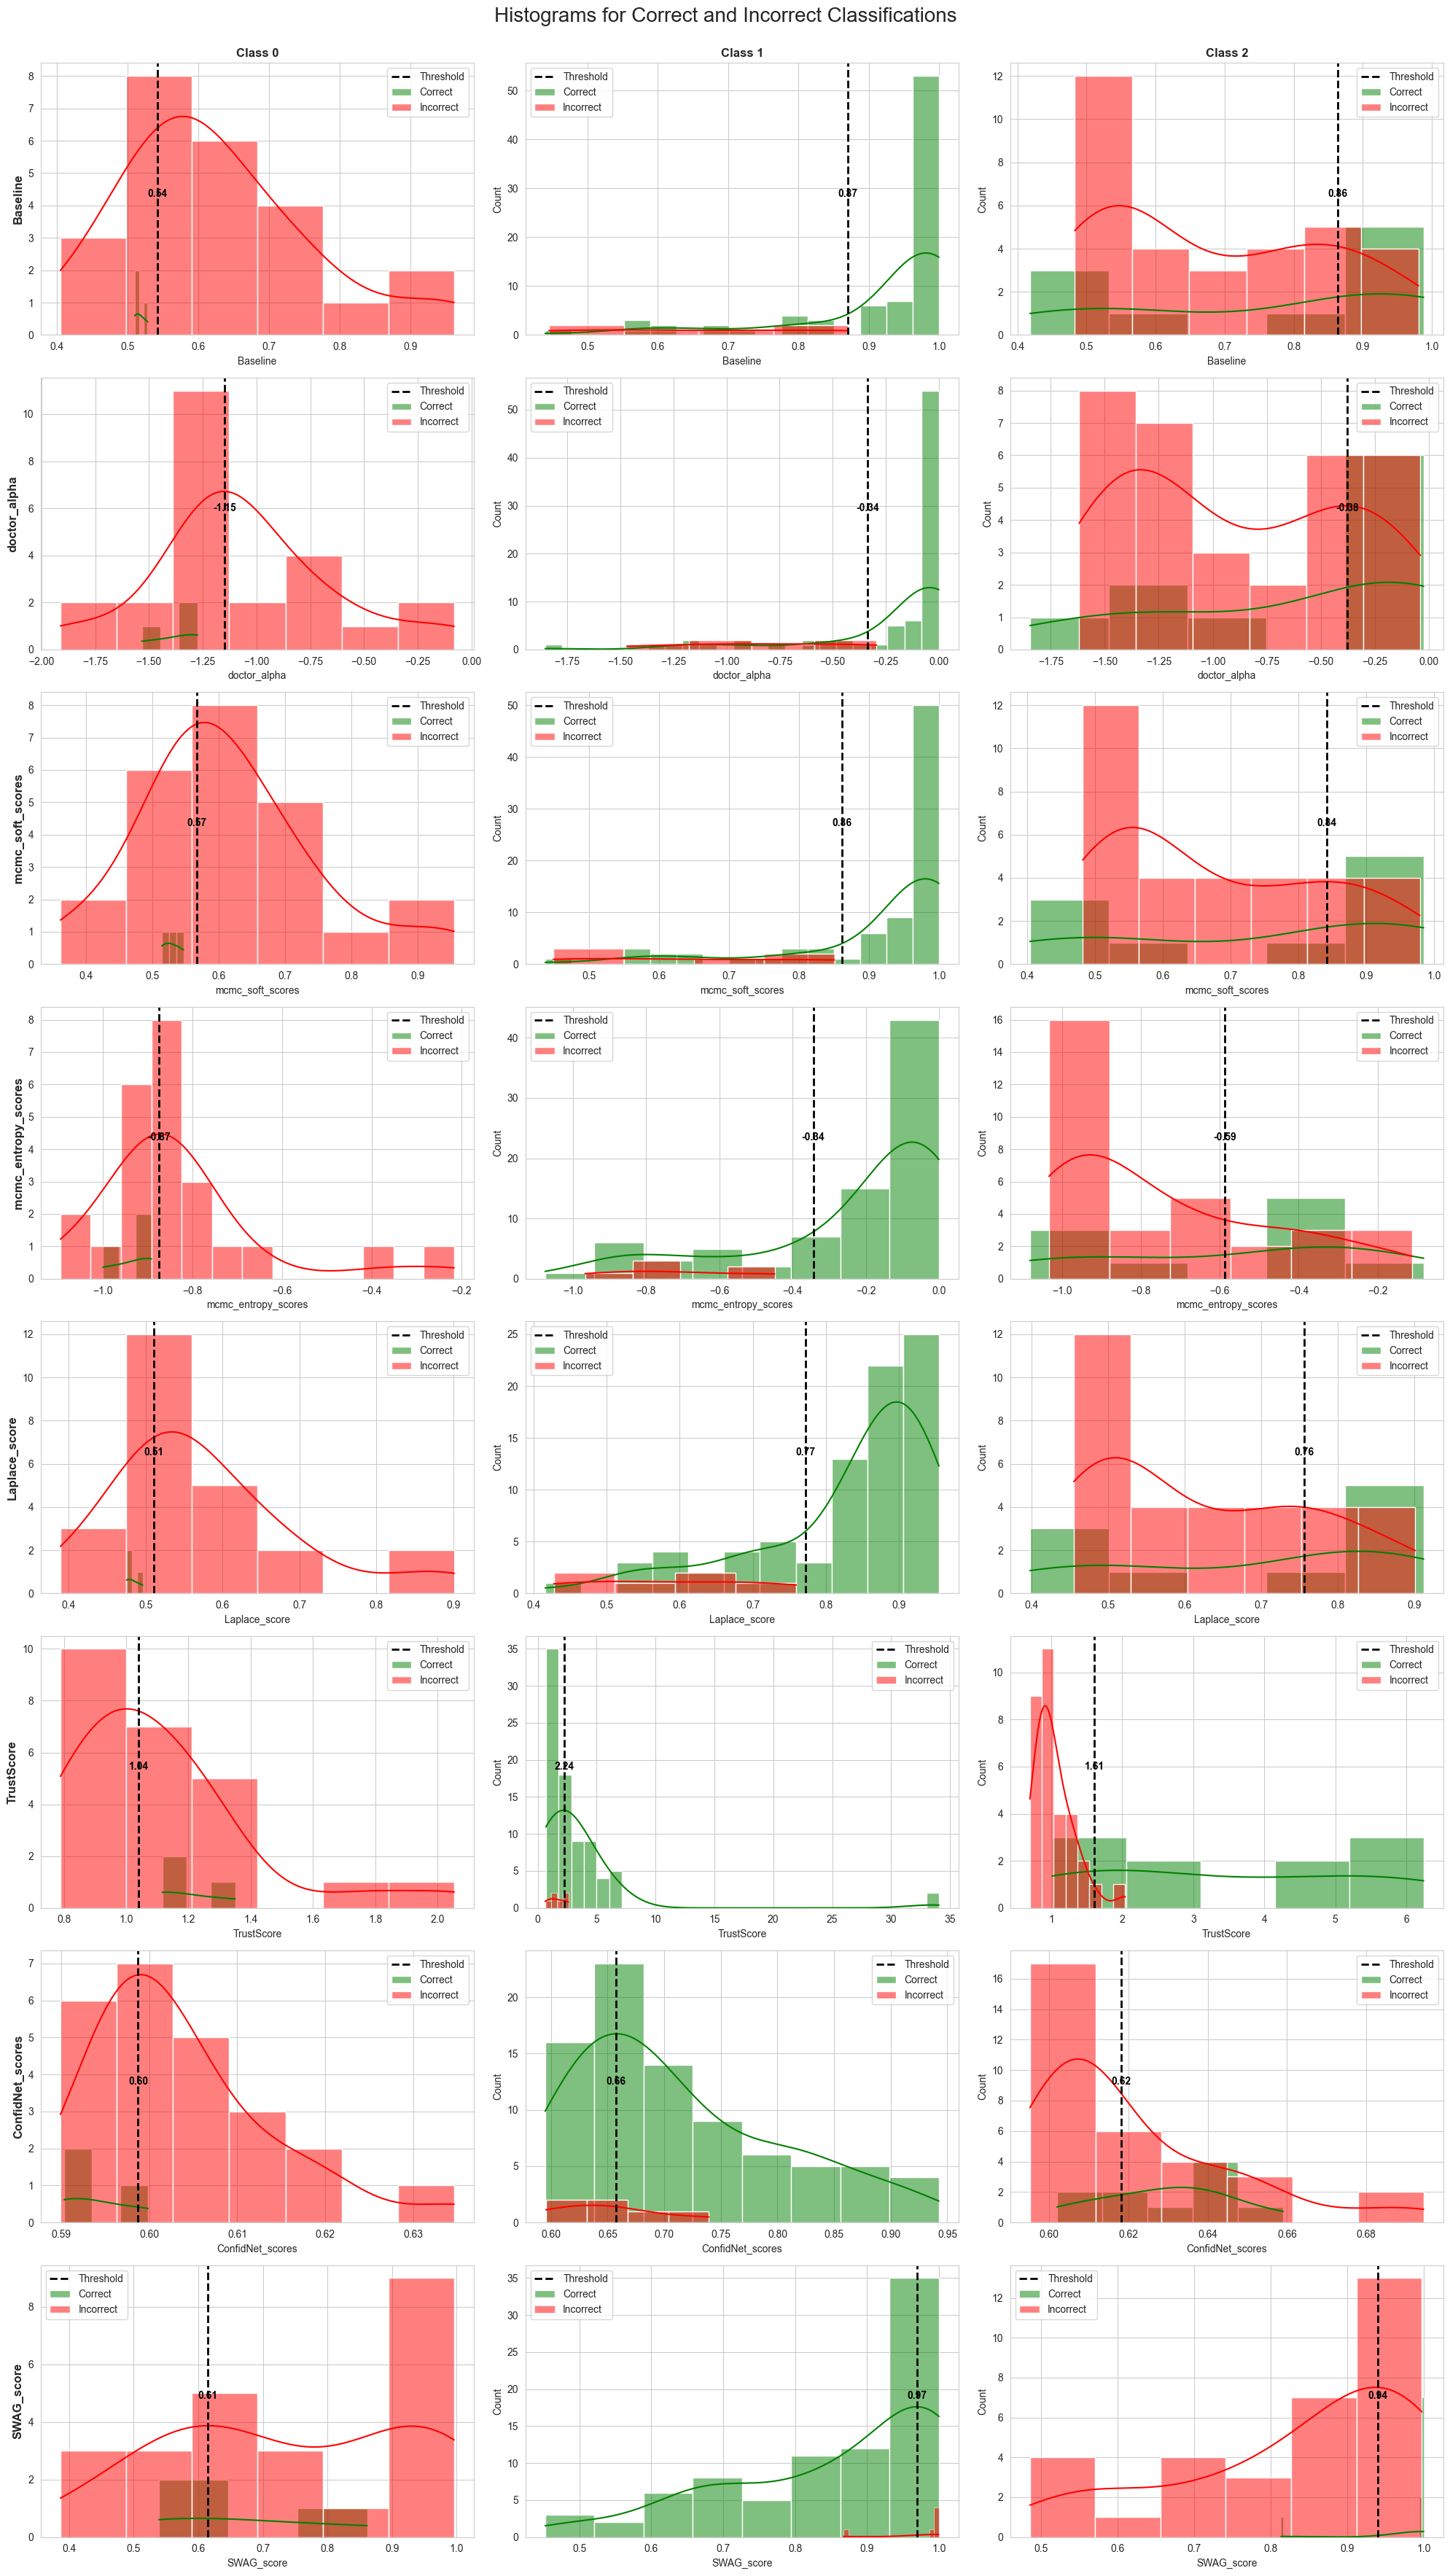

In [5]:
# Necessary Imports
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define scoring methods
scoring_methods = [
    'Baseline', 'doctor_alpha', 'mcmc_soft_scores', 'mcmc_entropy_scores',
    'Laplace_score', 'TrustScore', 'ConfidNet_scores', 'SWAG_score'
]

# Extract unique classes from the dataframe
classes = scores_df["Targets"].unique()

# Create a figure with 8 rows and 3 columns (8 scoring methods x 3 classes)
fig, axes = plt.subplots(nrows=len(scoring_methods), ncols=len(classes), figsize=(20, 36))  # Increased figsize

fig.subplots_adjust(top=0.93,hspace=0.5)  # Adjust top to create space for the suptitle

# Add suptitle above the subplots
plt.subplots_adjust(top=0.93, hspace=0.5)  # Adjust overall top margin and add blank space with hspace
fig.suptitle('Histograms for Correct and Incorrect Classifications', fontsize=20, y=0.98)

thresholds = {}

for row, method in enumerate(scoring_methods):
    for col, cls in enumerate(classes):
        # Get the appropriate axis for this subplot
        ax = axes[row, col]

        # Separate the data into correct and incorrect classifications for the current class and scoring method
        correct = scores_df[(scores_df['Targets'] == cls) & (scores_df['IsCorrect'] == True)][method]
        incorrect = scores_df[(scores_df['Targets'] == cls) & (scores_df['IsCorrect'] == False)][method]

        # Find the optimal threshold using KDE without clearing histograms
        x_vals = np.linspace(min(scores_df[method]), max(scores_df[method]), 1000)
        correct_kde = sns.kdeplot(correct, ax=ax).get_lines()[0].get_data()
        incorrect_kde = sns.kdeplot(incorrect, ax=ax).get_lines()[1].get_data()
        ax.clear()

        # Plot histograms
        sns.histplot(correct, kde=True, color='green', label='Correct', ax=ax)
        sns.histplot(incorrect, kde=True, color='red', label='Incorrect', ax=ax)

        correct_interp = np.interp(x_vals, correct_kde[0], correct_kde[1])
        incorrect_interp = np.interp(x_vals, incorrect_kde[0], incorrect_kde[1])

        overlap_vals = np.minimum(correct_interp, incorrect_interp)
        total_overlap_area = np.trapz(overlap_vals, x_vals)  # Compute area of overlap using np.trapz

        thresholds[(method, cls)] = x_vals[np.argmax(overlap_vals)]  # Minimizes overlap

        # Add threshold to the plot
        threshold = thresholds[(method, cls)]
        ax.axvline(x=threshold, color='black', linestyle='dashed', linewidth=2, label='Threshold')
        ax.text(threshold, 0.5 * ax.get_ylim()[1], f'{threshold:.2f}', color='black', fontsize=10, ha='center', va='bottom', fontweight='bold')

        # Set titles and labels
        if col == 0:
            ax.set_ylabel(method, fontsize=12, fontweight='bold')
        if row == 0:
            ax.set_title(f'Class {cls}', fontsize=12, fontweight='bold')

        ax.legend(fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.98])    # Ensures better layout of the plots
plt.show()

In [6]:
# Identify rows where the values of 'Targets' and 'SWAG_targets' differ
swag_inconsistent_rows = scores_df[
    scores_df["Targets"] != scores_df["SWAG_targets"]
]

# Identify rows where the values of 'Targets' and 'Laplace_targets' differ
laplace_inconsistent_rows = scores_df[
    scores_df["Targets"] != scores_df["Laplace_targets"]
]

# Print rows where 'SWAG_targets' differ from 'Targets'
print("Rows where 'SWAG_targets' differ from 'Targets':")
display(swag_inconsistent_rows)

# Print rows where 'Laplace_targets' differ from 'Targets'
print("\nRows where 'Laplace_targets' differ from 'Targets':")
laplace_inconsistent_rows

Rows where 'SWAG_targets' differ from 'Targets':


,Targets,Predictions,IsCorrect,Baseline,doctor_alpha,mcmc_soft_scores,mcmc_predictions,mcmc_entropy_scores,Laplace_targets,Laplace_predictions,Laplace_score,TrustScore,ConfidNet_scores,SWAG_targets,SWAG_predictions,SWAG_score



Rows where 'Laplace_targets' differ from 'Targets':


,Targets,Predictions,IsCorrect,Baseline,doctor_alpha,mcmc_soft_scores,mcmc_predictions,mcmc_entropy_scores,Laplace_targets,Laplace_predictions,Laplace_score,TrustScore,ConfidNet_scores,SWAG_targets,SWAG_predictions,SWAG_score


In [7]:
laplace_inconsistent_rows["Laplace_targets"].unique()

array([], dtype=int64)

In [8]:
scores_df.shape

(157, 16)

In [9]:
scores_df[scores_df["Targets"] == 0]

,Targets,Predictions,IsCorrect,Baseline,doctor_alpha,mcmc_soft_scores,mcmc_predictions,mcmc_entropy_scores,Laplace_targets,Laplace_predictions,Laplace_score,TrustScore,ConfidNet_scores,SWAG_targets,SWAG_predictions,SWAG_score
0,0,1,False,0.524360,-1.434551,0.530867,1,-0.980445,0,1,0.484521,0.816372,0.602818,0,0,0.631612
1,0,1,False,0.961555,-0.080605,0.954375,1,-0.215710,0,1,0.901099,1.194050,0.634637,0,0,0.587070
2,0,1,False,0.572684,-1.147635,0.556334,1,-0.867243,0,1,0.533369,1.030615,0.596464,0,0,0.922435
3,0,1,False,0.534838,-1.157264,0.529195,1,-0.841670,0,1,0.507450,0.919911,0.598270,0,0,0.638138
4,0,1,False,0.510129,-1.142973,0.527342,1,-0.849199,0,1,0.487452,0.789352,0.614923,0,1,0.661010
5,0,0,True,0.528442,-1.274218,0.546625,0,-0.891404,0,0,0.496150,1.115984,0.592022,0,0,0.539018
6,0,1,False,0.703891,-0.839468,0.677903,1,-0.826527,0,1,0.638740,1.027157,0.606035,0,1,0.590078
7,0,1,False,0.598188,-1.143667,0.593355,1,-0.880180,0,1,0.547339,0.844737,0.611053,0,0,0.966106
8,0,1,False,0.766684,-0.620606,0.732987,1,-0.748201,0,1,0.693100,1.257866,0.605115,0,0,0.752753
9,0,1,False,0.570567,-1.209408,0.561722,1,-0.896920,0,1,0.522285,1.009728,0.598032,0,0,0.981012


In [10]:
incorrect_classifications = scores_df[(scores_df['IsCorrect'] == False)]
incorrect_classifications.head()

,Targets,Predictions,IsCorrect,Baseline,doctor_alpha,mcmc_soft_scores,mcmc_predictions,mcmc_entropy_scores,Laplace_targets,Laplace_predictions,Laplace_score,TrustScore,ConfidNet_scores,SWAG_targets,SWAG_predictions,SWAG_score
0,0,1,False,0.524360,-1.434551,0.530867,1,-0.980445,0,1,0.484521,0.816372,0.602818,0,0,0.631612
1,0,1,False,0.961555,-0.080605,0.954375,1,-0.215710,0,1,0.901099,1.194050,0.634637,0,0,0.587070
2,0,1,False,0.572684,-1.147635,0.556334,1,-0.867243,0,1,0.533369,1.030615,0.596464,0,0,0.922435
3,0,1,False,0.534838,-1.157264,0.529195,1,-0.841670,0,1,0.507450,0.919911,0.598270,0,0,0.638138
4,0,1,False,0.510129,-1.142973,0.527342,1,-0.849199,0,1,0.487452,0.789352,0.614923,0,1,0.661010


In [11]:
scores_df[scores_df["Targets"] == 1]

,Targets,Predictions,IsCorrect,Baseline,doctor_alpha,mcmc_soft_scores,mcmc_predictions,mcmc_entropy_scores,Laplace_targets,Laplace_predictions,Laplace_score,TrustScore,ConfidNet_scores,SWAG_targets,SWAG_predictions,SWAG_score
27,1,1,True,0.971827,-0.058374,0.968379,1,-0.162177,1,1,0.885112,1.776458,0.672329,1,1,0.562230
28,1,1,True,0.559990,-1.146055,0.562643,1,-0.846557,1,1,0.524342,1.010632,0.597028,1,1,0.472144
29,1,2,False,0.870830,-0.293684,0.850694,2,-0.459570,1,2,0.759331,2.607892,0.643200,1,2,0.993020
30,1,1,True,0.618846,-1.088321,0.610385,1,-0.869039,1,1,0.565592,1.204130,0.598844,1,0,0.770831
31,1,1,True,0.566097,-1.217349,0.557940,1,-0.897498,1,1,0.526609,1.127957,0.598807,1,0,0.948215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,1,1,True,0.971664,-0.058577,0.972131,1,-0.142071,1,1,0.896056,1.894011,0.677582,1,2,0.652055
111,1,1,True,0.965311,-0.071819,0.965810,1,-0.152805,1,1,0.827448,2.658539,0.743220,1,1,0.861653
112,1,1,True,0.780446,-0.575265,0.774784,1,-0.681074,1,1,0.706079,1.178257,0.604435,1,1,0.717562
113,1,1,True,0.993503,-0.013083,0.994723,1,-0.034062,1,1,0.653964,3.606899,0.917131,1,1,0.861966


In [12]:
scores_df[scores_df["Targets"] == 2]

,Targets,Predictions,IsCorrect,Baseline,doctor_alpha,mcmc_soft_scores,mcmc_predictions,mcmc_entropy_scores,Laplace_targets,Laplace_predictions,Laplace_score,TrustScore,ConfidNet_scores,SWAG_targets,SWAG_predictions,SWAG_score
115,2,1,False,0.964454,-0.073927,0.962559,1,-0.174798,2,1,0.898578,1.405873,0.653667,2,1,0.905439
116,2,2,True,0.572975,-1.009816,0.539679,2,-0.772903,2,2,0.536492,1.648712,0.626129,2,2,0.995505
117,2,2,True,0.869936,-0.300816,0.857029,2,-0.481023,2,2,0.764742,2.432123,0.624040,2,2,0.999972
118,2,1,False,0.543590,-1.422508,0.551918,1,-0.962320,2,1,0.500905,1.021698,0.605744,2,2,0.865916
119,2,1,False,0.601357,-1.143436,0.589218,1,-0.917436,2,1,0.547986,0.877677,0.606606,2,2,0.825153
120,2,1,False,0.557012,-1.182261,0.562000,1,-0.898197,2,1,0.516403,0.808961,0.610433,2,2,0.790997
121,2,2,True,0.516085,-1.369334,0.475259,2,-0.983600,2,2,0.477577,1.309720,0.602008,2,2,0.813542
122,2,1,False,0.548745,-1.476497,0.559617,1,-0.991257,2,1,0.503226,0.699158,0.603520,2,2,0.969238
123,2,1,False,0.862825,-0.315968,0.868166,1,-0.441933,2,1,0.773502,0.982922,0.642090,2,1,0.541605
124,2,2,True,0.919757,-0.174253,0.903460,2,-0.344211,2,2,0.820402,6.180864,0.637064,2,2,0.999604
